In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,Dense,MaxPooling2D,Dropout,Flatten
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import pandas as pd
import random
import ntpath

Using TensorFlow backend.


In [2]:
!git clone https://github.com/rslim087a/track
  

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 31.22 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [3]:
!ls

sample_data  track


In [0]:
# creating a data set
datadir='track'
column = ['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=column)

In [5]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [0]:
# center and steering are usefull columns so droping all other columns
data=data[['center','steering']]

In [7]:
data.head()

,center,steering
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,0.0
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,0.0
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,0.0
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,0.0
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,0.0


In [0]:
# correcting the path of image in center column 
data['center']=data['center'].apply(lambda x:str(x).split('\\')[-1])

In [9]:
data.head()

,center,steering
0,center_2018_07_16_17_11_43_382.jpg,0.0
1,center_2018_07_16_17_11_43_670.jpg,0.0
2,center_2018_07_16_17_11_43_724.jpg,0.0
3,center_2018_07_16_17_11_43_792.jpg,0.0
4,center_2018_07_16_17_11_43_860.jpg,0.0


In [10]:
num_bins=25
hist,bins=np.histogram(data['steering'],num_bins)
type(hist)

numpy.ndarray

In [11]:
print(len(hist))
print(len(bins))

25
26


In [12]:
# equalizing the len of hist and bins
center=(bins[:-1]+bins[1:])*0.5
print(center)

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


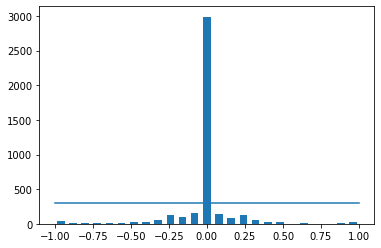

In [13]:
samples_per_bin=300
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [14]:
print('total data',len(data))

total data 4053


removed: 2690
remaining: 1363
[ 35   6   6   6  13   8  24  22  53 131  99 158 300 137  86 126  54  22
  19   2   9   4   4   6  33]


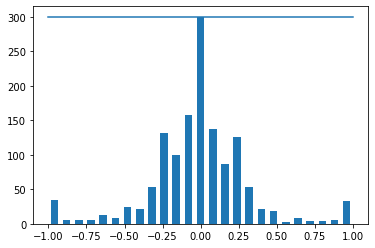

In [15]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
print(hist)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [16]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center = indexed_data[0]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[1]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

center      center_2018_07_16_17_11_44_485.jpg
steering                                 -0.25
Name: 13, dtype: object


In [0]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))


Training Samples: 1090
Valid Samples: 273


Text(0.5, 1.0, 'Validation set')

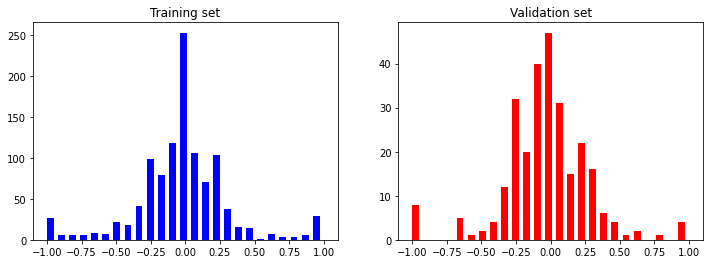

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

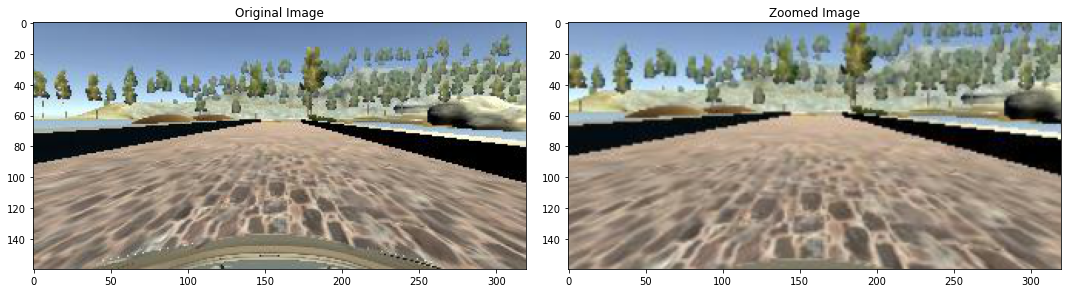

In [20]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

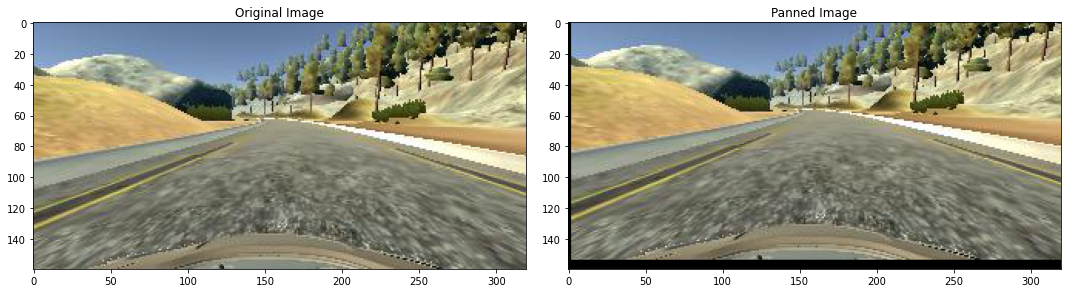

In [21]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

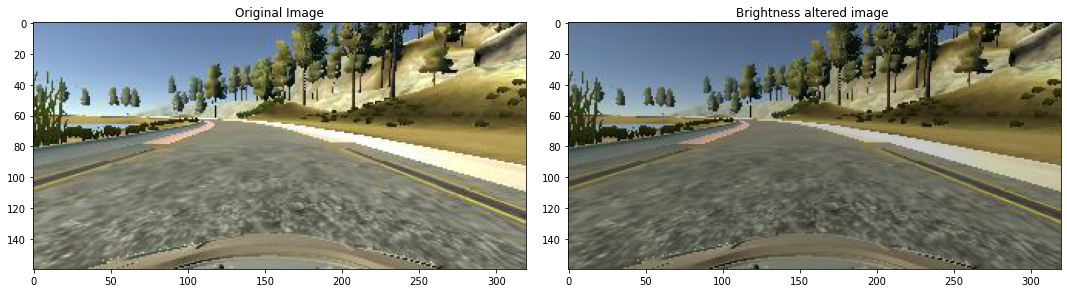

In [22]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.02750129')

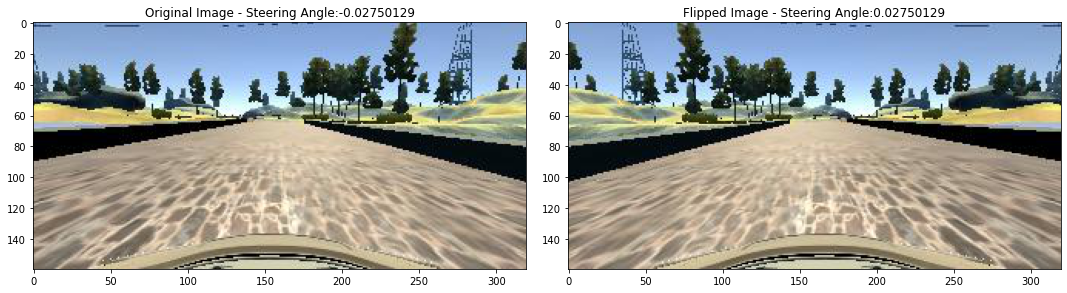

In [23]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [24]:
np.random.rand()

0.9327924801916785

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

In [26]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'Preprocessed Image')

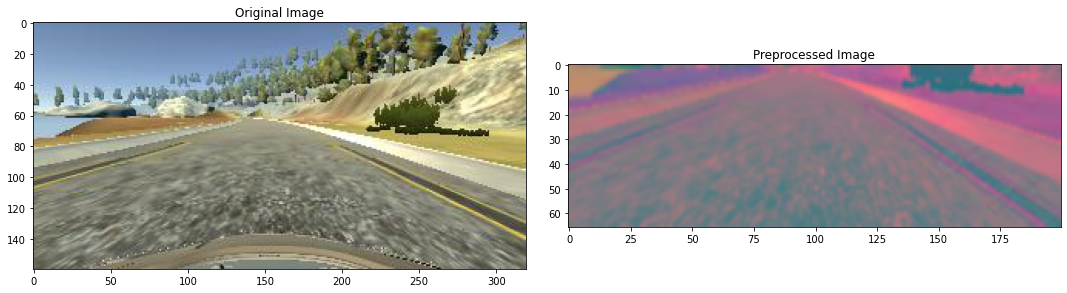

In [27]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
  
  
  
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
      
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [0]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

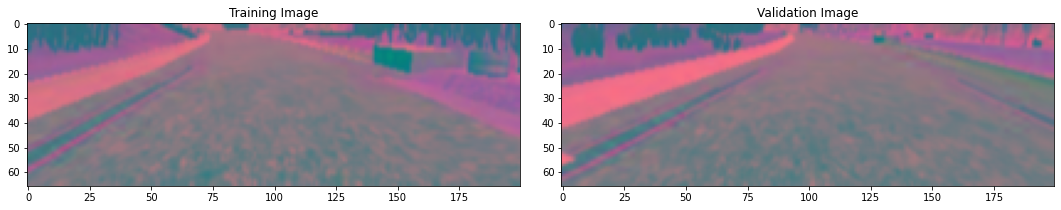

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  #model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer,metrics=["accuracy"])
  return model

In [32]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  


In [33]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=5,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)


Epoch 1/5
300/300 [==============================] - 422s 1s/step - loss: 0.0887 - accuracy: 0.2276 - val_loss: 0.0487 - val_accuracy: 0.1841
Epoch 2/5
300/300 [==============================] - 417s 1s/step - loss: 0.0675 - accuracy: 0.2342 - val_loss: 0.0635 - val_accuracy: 0.1949
Epoch 3/5
300/300 [==============================] - 416s 1s/step - loss: 0.0637 - accuracy: 0.2412 - val_loss: 0.0567 - val_accuracy: 0.1938
Epoch 4/5
300/300 [==============================] - 415s 1s/step - loss: 0.0593 - accuracy: 0.2474 - val_loss: 0.0572 - val_accuracy: 0.2033
Epoch 5/5
300/300 [==============================] - 418s 1s/step - loss: 0.0532 - accuracy: 0.2510 - val_loss: 0.0379 - val_accuracy: 0.1927


Text(0.5, 0, 'Epoch')

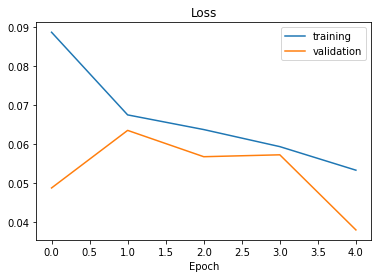

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
plt.plot(history.history['ac'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'va_acc'])
plt.title('Accuracy')


KeyError: ignored

In [0]:
# conda install -c conda-forge tensorflow
# python-socketio
# eventlet
# flask


In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')

In [0]:
pwd


'/content'